In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "5"

dhcp-10-31-130-63.dyn.MIT.EDU
/Users/akarshkumar0101/synthetic-mdps/src
/Users/akarshkumar0101/miniconda3/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [4]:
import lovely_jax as lj
lj.monkey_patch()

In [5]:
rng = jax.random.PRNGKey(0)
# jax.random.ball(rng, 10)

In [11]:
model_init = csmdp.Init(d_state=2, std=1e-1)
model_trans = csmdp.Transition(d_state=2, n_acts=3, n_layers=2, d_hidden=16, activation=nn.gelu, locality=1e-1, std=0.)
model_obs = csmdp.Observation(d_state=2, d_obs=32, n_layers=2, d_hidden=16, activation=nn.gelu, std=0.)
model_rew = csmdp.Reward(d_state=2, n_layers=2, d_hidden=16, activation=nn.gelu, std=0.)
model_done = csmdp.Done(d_state=2, n_layers=2, d_hidden=16, activation=nn.gelu, std=0.)
env = smdp.SyntheticMDP(model_init, model_trans, model_obs, model_rew, model_done)

env_params = env.sample_params(rng)

In [12]:
env.reset(rng, env_params)

(Array[32] x∈[-0.746, 1.253] μ=0.038 σ=0.464 cpu:0,
 Array[2] μ=0.016 σ=0.632 cpu:0 [0.647, -0.616])

In [ ]:
def create_smdp():
    pass

In [6]:
from mdps import smdp, csmdp, dsmdp, mdsmdp

In [429]:
def plot_csmdp_env(env, env_params):
    rng = jax.random.PRNGKey(0)
    n_res = 30
    
    assert isinstance(env.model_init, csmdp.Init)
    assert env.model_init.d_state == 2
    
    n_acts = env.model_trans.n_acts
    cols = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w'][:n_acts]

    xlim = ylim = jnp.array([-3., 3.])
    x, y = jnp.linspace(*xlim, n_res), jnp.linspace(*ylim, n_res)
    xm, ym = jnp.meshgrid(x, y, indexing='ij')
    state_all = rearrange(jnp.stack([xm, ym], axis=-1), "i j d -> (i j) d")

    rew_all = jax.vmap(env.get_rew, in_axes=(None, 0, None))(rng, state_all, env_params)
    done_all = jax.vmap(env.is_done, in_axes=(None, 0, None))(rng, state_all, env_params)
    rew_all = rearrange(rew_all, '(i j) -> i j', i=n_res, j=n_res) # needs to be reversed for pcolormesh
    done_all = rearrange(done_all, '(i j) -> i j', i=n_res, j=n_res).astype(float)
    plt.pcolormesh(xm, ym, rew_all, alpha=0.8, vmin=-3., vmax=3., cmap='RdYlGn')
    plt.colorbar()

    done_all = jnp.stack([jnp.zeros_like(done_all)] * 3 + [done_all], axis=-1)
    plt.pcolormesh(xm, ym, done_all)

    step_fn = jax.vmap(jax.vmap(env.step_env, in_axes=(None, 0, None, None)), in_axes=(None, None, 0, None))
    act = jnp.arange(n_acts)
    _, state_all_n, _, _, _ = step_fn(rng, state_all, act, env_params)

    state, state_n = repeat(state_all, 'ij d -> (a ij) d', a=n_acts), rearrange(state_all_n, 'a ij d -> (a ij) d')
    c = []
    for col in cols:
        c.extend([col] * (n_res * n_res))
    plt.quiver(*state.T, *(state_n - state).T, angles='xy', scale_units='xy', scale=1, width=0.002, color=c)

    obs, state = jax.vmap(env.reset_env, in_axes=(0, None))(split(rng, 256), env_params)
    plt.scatter(*state.T, color=(0, 0, 0, 0.4), edgecolors='none', label='init state distribution')

    # buffer = random_agent_collect(rng, env, env_params, n_envs=1024, n_steps=256)
    #
    # state = rearrange(buffer['state'], 'N T ... -> (N T) ...')  # (N T) D=2
    # plt.scatter(*state.T, color=(0, 0, 1, 0.01), label='random walk state distribution')
    # state = buffer['state'][:, 0]  # N T D=2
    # plt.scatter(*state.T, color=(0, 0, 0, 1.), label='init state distribution')

    # put legend above figure
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))

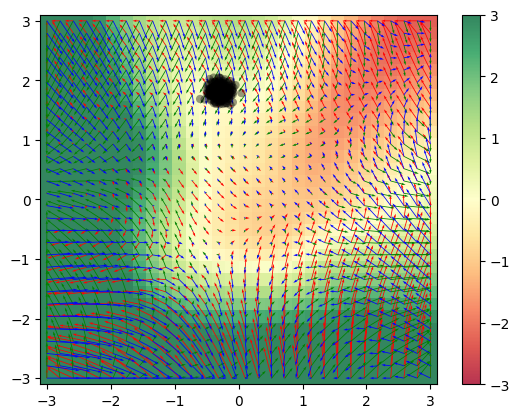

In [430]:
model_init = csmdp.Init(d_state=2, std=1e-1)
model_trans = csmdp.Transition(d_state=2, n_acts=3, n_layers=2, d_hidden=16, activation=nn.gelu, locality=1e-1, std=0.)
model_obs = csmdp.Observation(d_state=2, d_obs=32, n_layers=2, d_hidden=16, activation=nn.gelu, std=0.)
model_rew = csmdp.Reward(d_state=2, n_layers=2, d_hidden=16, activation=nn.gelu, std=0.)
model_done = csmdp.Done(d_state=2, n_layers=2, d_hidden=16, activation=nn.gelu, std=0.)
env = smdp.SyntheticMDP(model_init, model_trans, model_obs, model_rew, model_done)

rng = jax.random.PRNGKey(7)
env_params = env.sample_params(rng)
plot_csmdp_env(env, env_params)
plt.show()

In [431]:
def plot_dsmdp_env(env, env_params):
    rng = jax.random.PRNGKey(0)
    assert isinstance(env.model_init, dsmdp.Init)
    
    n = env.model_init.n
    n_acts = env.model_trans.n_acts
    cols = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w'][:n_acts]
    
    state_all = jnp.arange(n)
    rew_all = jax.vmap(env.get_rew, in_axes=(None, 0, None))(rng, state_all, env_params)
    done_all = jax.vmap(env.is_done, in_axes=(None, 0, None))(rng, state_all, env_params)
    
    x = jax.random.uniform(rng, (n, 2), minval=-1, maxval=1.)
    plt.scatter(*x[state_all].T, c=rew_all, s=500, alpha=0.8, vmin=-3., vmax=3., cmap='RdYlGn')
    plt.colorbar()
    for i in range(n):
        plt.text(*x[i], f"{i:2d}", horizontalalignment="center", verticalalignment="center")
    
    # done_all = jnp.stack([jnp.zeros_like(done_all)] * 3 + [done_all], axis=-1)
    # plt.pcolormesh(xm, ym, done_all)

    step_fn = jax.vmap(jax.vmap(env.step_env, in_axes=(None, 0, None, None)), in_axes=(None, None, 0, None))
    act = jnp.arange(n_acts)
    _, state_all_n, _, _, _ = step_fn(rng, state_all, act, env_params)
    
    state, state_n = repeat(state_all, 'i -> (a i)', a=n_acts), rearrange(state_all_n, 'a i -> (a i)')
    
    c = []
    for col in cols:
        c.extend([col] * (n))
    plt.quiver(*x[state].T, *(x[state_n] - x[state]).T, angles='xy', scale_units='xy', scale=1, width=0.004, headwidth=6, color=c, alpha=0.8)
    plt.show()

    # obs, state = jax.vmap(env.reset_env, in_axes=(0, None))(split(rng, 256), env_params)
    # plt.scatter(*state.T, color=(0, 0, 0, 0.4), edgecolors='none', label='init state distribution')

    # buffer = random_agent_collect(rng, env, env_params, n_envs=1024, n_steps=256)
    #
    # state = rearrange(buffer['state'], 'N T ... -> (N T) ...')  # (N T) D=2
    # plt.scatter(*state.T, color=(0, 0, 1, 0.01), label='random walk state distribution')
    # state = buffer['state'][:, 0]  # N T D=2
    # plt.scatter(*state.T, color=(0, 0, 0, 1.), label='init state distribution')

    # put legend above figure
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))

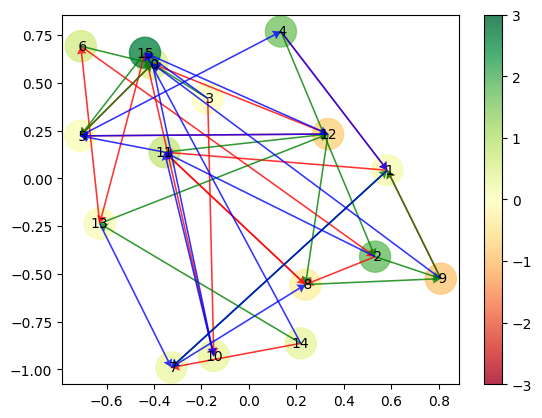

In [432]:
model_init = dsmdp.Init(16, temperature=1.)
model_trans = dsmdp.Transition(16, 3, temperature=0.01)
model_obs = dsmdp.Observation(16, 32, std=0.)
model_rew = dsmdp.Reward(16, std=0.)
model_done = dsmdp.Done(16, std=0.)
env = smdp.SyntheticMDP(model_init, model_trans, model_obs, model_rew, model_done)


rng = jax.random.PRNGKey(7)
env_params = env.sample_params(rng)
plot_dsmdp_env(env, env_params)
plt.show()

In [531]:
def plot_mdsmdp_env(env, env_params):
    import itertools
    rng = jax.random.PRNGKey(0)
    assert isinstance(env.model_init, mdsmdp.Init)
    
    m, n = env.model_init.m, env.model_init.n
    n_acts = env.model_trans.n_acts
    cols = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w'][:n_acts]
    
    
    state_all = jnp.array(list(itertools.product(range(2), repeat=4)))
    rew_all = jax.vmap(env.get_rew, in_axes=(None, 0, None))(rng, state_all, env_params)
    done_all = jax.vmap(env.is_done, in_axes=(None, 0, None))(rng, state_all, env_params)
    
    x = jax.random.uniform(rng, (n**m, 2), minval=-1, maxval=1.)
    plt.scatter(*x.T, c=rew_all, s=500, alpha=0.8, vmin=-3., vmax=3., cmap='RdYlGn')
    plt.colorbar()
    for i, state in enumerate(state_all):
        s = ",".join([f"{j}" for j in state.tolist()])
        plt.text(*x[i], s, horizontalalignment="center", verticalalignment="center")
    
    # done_all = jnp.stack([jnp.zeros_like(done_all)] * 3 + [done_all], axis=-1)
    # plt.pcolormesh(xm, ym, done_all)

    step_fn = jax.vmap(jax.vmap(env.step_env, in_axes=(None, 0, None, None)), in_axes=(None, None, 0, None))
    act = jnp.arange(n_acts)
    _, state_all_n, _, _, _ = step_fn(rng, state_all, act, env_params)
    
    state, state_n = repeat(state_all, 'i d -> (a i) d', a=n_acts), rearrange(state_all_n, 'a i d -> (a i) d')
    # print(state.shape, state_n.shape)
    state = (state*(n**jnp.arange(m-1, -1, -1))).sum(axis=-1)
    state_n = (state_n*(n**jnp.arange(m-1, -1, -1))).sum(axis=-1)
    
    c = []
    for col in cols:
        c.extend([col] * (n**m))
    plt.quiver(*x[state].T, *(x[state_n] - x[state]).T, angles='xy', scale_units='xy', scale=1, width=0.004, headwidth=6, color=c, alpha=0.8)
    plt.show()

    # obs, state = jax.vmap(env.reset_env, in_axes=(0, None))(split(rng, 256), env_params)
    # plt.scatter(*state.T, color=(0, 0, 0, 0.4), edgecolors='none', label='init state distribution')

    # buffer = random_agent_collect(rng, env, env_params, n_envs=1024, n_steps=256)
    #
    # state = rearrange(buffer['state'], 'N T ... -> (N T) ...')  # (N T) D=2
    # plt.scatter(*state.T, color=(0, 0, 1, 0.01), label='random walk state distribution')
    # state = buffer['state'][:, 0]  # N T D=2
    # plt.scatter(*state.T, color=(0, 0, 0, 1.), label='init state distribution')

    # put legend above figure
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))

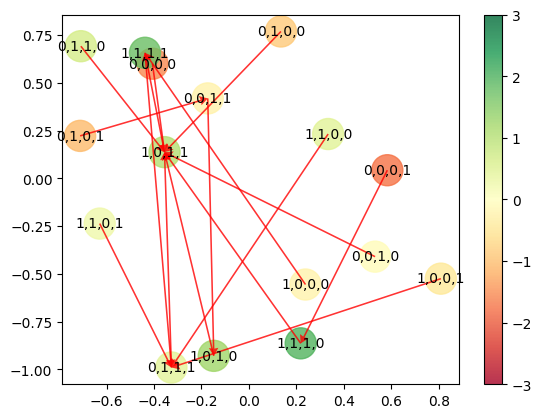

In [544]:
model_init = mdsmdp.Init(4, 2, temperature=1.)
model_trans = mdsmdp.Transition(4, 2, 1, temperature=1.)
model_obs = mdsmdp.Observation(4, 2, 32, )
model_rew = mdsmdp.Reward(4, 2, )
model_done = mdsmdp.Done(4, 2)
env = smdp.SyntheticMDP(model_init, model_trans, model_obs, model_rew, model_done)

rng = jax.random.PRNGKey(7)
env_params = env.sample_params(rng)
plot_mdsmdp_env(env, env_params)
plt.show()

In [ ]:
def plot_csmdp_env(env, env_params):
    rng = jax.random.PRNGKey(0)
    n_res = 30
    
    assert isinstance(env.model_init, csmdp.Init)
    assert env.model_init.d_state == 2
    
    n_acts = env.model_trans.n_acts
    cols = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w'][:n_acts]

    xlim = ylim = jnp.array([-3., 3.])
    x, y = jnp.linspace(*xlim, n_res), jnp.linspace(*ylim, n_res)
    xm, ym = jnp.meshgrid(x, y, indexing='ij')
    state_all = rearrange(jnp.stack([xm, ym], axis=-1), "i j d -> (i j) d")

    rew_all = jax.vmap(env.get_rew, in_axes=(None, 0, None))(rng, state_all, env_params)
    done_all = jax.vmap(env.is_done, in_axes=(None, 0, None))(rng, state_all, env_params)
    rew_all = rearrange(rew_all, '(i j) -> i j', i=n_res, j=n_res) # needs to be reversed for pcolormesh
    done_all = rearrange(done_all, '(i j) -> i j', i=n_res, j=n_res).astype(float)
    plt.pcolormesh(xm, ym, rew_all, alpha=0.8, vmin=-3., vmax=3., cmap='RdYlGn')
    plt.colorbar()

    done_all = jnp.stack([jnp.zeros_like(done_all)] * 3 + [done_all], axis=-1)
    plt.pcolormesh(xm, ym, done_all)

    step_fn = jax.vmap(jax.vmap(env.step_env, in_axes=(None, 0, None, None)), in_axes=(None, None, 0, None))
    act = jnp.arange(n_acts)
    _, state_all_n, _, _, _ = step_fn(rng, state_all, act, env_params)

    state, state_n = repeat(state_all, 'ij d -> (a ij) d', a=n_acts), rearrange(state_all_n, 'a ij d -> (a ij) d')
    c = []
    for col in cols:
        c.extend([col] * (n_res * n_res))
    plt.quiver(*state.T, *(state_n - state).T, angles='xy', scale_units='xy', scale=1, width=0.002, color=c)

    obs, state = jax.vmap(env.reset_env, in_axes=(0, None))(split(rng, 256), env_params)
    plt.scatter(*state.T, color=(0, 0, 0, 0.4), edgecolors='none', label='init state distribution')

    # buffer = random_agent_collect(rng, env, env_params, n_envs=1024, n_steps=256)
    #
    # state = rearrange(buffer['state'], 'N T ... -> (N T) ...')  # (N T) D=2
    # plt.scatter(*state.T, color=(0, 0, 1, 0.01), label='random walk state distribution')
    # state = buffer['state'][:, 0]  # N T D=2
    # plt.scatter(*state.T, color=(0, 0, 0, 1.), label='init state distribution')

    # put legend above figure
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))

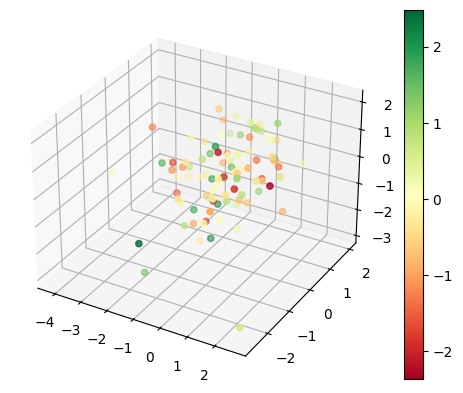

In [543]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(np.random.randn(100), np.random.randn(100), np.random.randn(100), c=np.random.randn(100), cmap='RdYlGn')
fig.colorbar(p, ax=ax)
plt.show()

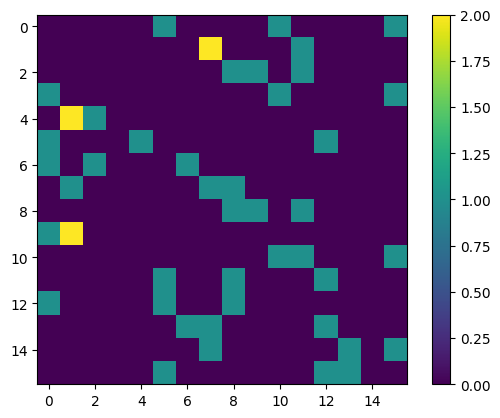

In [381]:
plt.imshow(jax.nn.softmax(env_params['trans']['trans_matrix']/0.0001, axis=-1).sum(axis=0))
plt.colorbar()
plt.show()

In [386]:
A = jax.nn.softmax(env_params['trans']['trans_matrix']/0.00001, axis=-1).sum(axis=0)

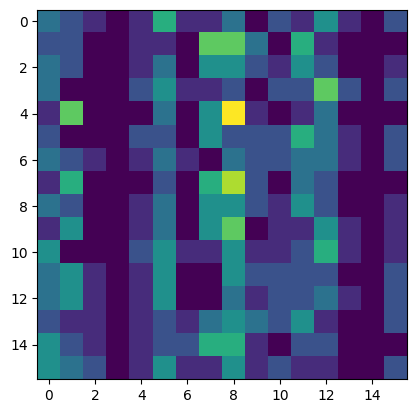

In [389]:
plt.imshow(jnp.linalg.matrix_power(A, 3))
plt.show()

In [545]:
A

Array[16, 16] n=256 (1Kb) x∈[0., 2.000] μ=0.188 σ=0.419 cpu:0